In [14]:
import matplotlib.pyplot as plt


In [21]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

x = mnist_train
y = mnist_test

train_idx = mnist_train.train_labels <= 1 
#x.train_data = mnist_train.train_data[train_idx]
#x.train_labels = mnist_train.train_labels[train_idx]

test_idx = mnist_test.test_labels <= 1
#y.test_data = mnist_test.test_data[test_idx]
#y.test_labels = mnist_test.test_labels[test_idx]

train_loader = DataLoader(x, batch_size = 100, shuffle=True)
test_loader = DataLoader(y, batch_size = 100, shuffle=False)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# do a single pass over the data
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [17]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.098767	-138220.310092	0.098000	-283440.989687
0.098717	-415016.120885	0.098000	-566820.841562
0.098717	-691812.307187	0.098000	-850200.660000
0.098717	-968608.263333	0.098000	-1133580.576250
0.098717	-1245404.059687	0.098000	-1416960.341250
0.098717	-1522199.965625	0.098000	-1700340.108750
0.098717	-1798996.038958	0.098000	-1983719.981250
0.098717	-2075791.573333	0.098000	-2267099.821250
0.098717	-2352587.718750	0.098000	-2550479.737500
0.098717	-2629383.695208	0.098000	-2833859.560000


ValueError: only one element tensors can be converted to Python scalars

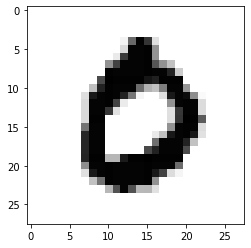

In [22]:
X_test = (test_loader.dataset.test_data.float()/255).view(len(test_loader.dataset),-1)
y_test = test_loader.dataset.test_labels
yp = model(X_test)[:,0]
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 1)
plt.imshow(1-X_test[idx][0].view(28,28).numpy(), cmap="gray")
plt.title("True Label: {}".format(y_test[idx].item()))

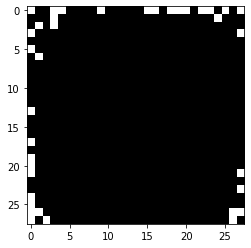

In [23]:
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

In [24]:
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

(0.1282, 18351062.41)


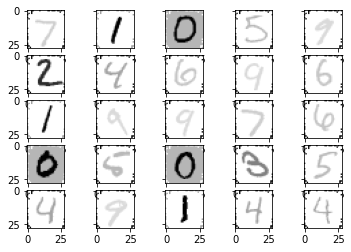

In [25]:
f,ax = plt.subplots(5,5, sharey=True)
for i in range(25):
    ax[i%5][i//5].imshow(1-(X_test[i].view(28,28) - (2*y_test[i]-1)*delta).numpy(), cmap="gray")
    ax

In [26]:
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [ ]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.129817	3683.225735	0.098000	1212.493588
0.098717	2584.307493	0.098000	1193.897347
0.098717	1520.190258	0.098000	570.739585
0.098717	508.770784	0.098000	219.844656
0.098717	-463.878924	0.098000	-596.792348
0.098717	-1308.553192	0.098000	-624.203654
0.098717	-2080.345951	0.098000	-3395.445229
0.098717	-2821.980045	0.098000	-2312.984557
0.098717	-3544.290467	0.098000	-4733.763513
0.098717	-4265.965851	0.098000	-5085.729976
0.098717	-4980.552233	0.098000	-4682.428679
0.098717	-5695.958453	0.098000	-6799.023311
0.098717	-6416.080098	0.098000	-5817.542632
0.098717	-7125.688732	0.098000	-6205.212793
0.098717	-7841.794151	0.098000	-9572.423013
0.098717	-8566.523738	0.098000	-9783.141133
0.098717	-9274.008755	0.098000	-9917.282129


In [ ]:
train_err, train_loss = epoch(train_loader, model)
test_err, test_loss = epoch(test_loader, model)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

In [ ]:
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")